In [1]:
import pandas as pd

df = pd.read_excel('./data/TraumaData.xlsx').drop(columns=['Unnamed: 0'])
df = df.rename(columns={c: c.lower().replace(' ', '_') for c in df.columns})
df = df.rename(columns={'65+_years': 'is_senior'})
df.shape

(50, 6)

In [2]:
df.head()

,prob_survival,severe_burn,head_injury,is_senior,male,hosp
0,0.694551,1,1,1,1,A
1,0.733619,1,1,1,0,A
2,0.785537,1,1,0,1,A
3,0.818770,1,0,1,1,A
4,0.868275,1,0,0,1,A


In [3]:
from patsy import dmatrices
import statsmodels.api as sm
import numpy as np

y, X = dmatrices('prob_survival ~ severe_burn + head_injury + is_senior + male + hosp', df, return_type='dataframe')
y = np.ravel(y)
X = X.iloc[:,1:]

X.shape, y.shape

((50, 8), (50,))

In [4]:
from sklearn.linear_model import LinearRegression

m1 = LinearRegression()
m1.fit(X, y)

c1 = pd.concat([
    pd.Series(m1.intercept_, ['intercept']), 
    pd.Series(m1.coef_, X.columns)
])

coefficients = pd.Series(m1.coef_, X.columns)

c1

intercept      1.162184
hosp[T.B]     -0.117932
hosp[T.C]     -0.226131
hosp[T.D]     -0.276450
hosp[T.E]     -0.341136
severe_burn   -0.245425
head_injury   -0.181782
is_senior     -0.109293
male          -0.026703
dtype: float64

In [5]:
hosp_df = pd.DataFrame({
    'tertiary_center': [1, 1, 0, 0, 0],
    'burn_center': [0, 1, 0, 0, 0],
    'y': [0] + list(m1.intercept_ - coefficients[:4])
}, index=['A', 'B', 'C', 'D', 'E'])

hosp_df

,tertiary_center,burn_center,y
A,1,0,0.000000
B,1,1,1.280116
C,0,0,1.388314
D,0,0,1.438634
E,0,0,1.503320


In [6]:
y, X = dmatrices('y ~ tertiary_center + burn_center', hosp_df, return_type='dataframe')
y = np.ravel(y)
X = X.iloc[:,1:]

X.shape, y.shape

((5, 2), (5,))

In [7]:
m2 = LinearRegression()
m2.fit(X, y)

c2 = pd.concat([
    pd.Series(m2.intercept_, ['intercept']), 
    pd.Series(m2.coef_, X.columns)
])

c2

intercept          1.443422
tertiary_center   -1.443422
burn_center        1.280116
dtype: float64

In [10]:
df['tertiary_center'] = df['hosp'].apply(lambda h: 1 if h in {'A', 'B'} else 0)
df['burn_center'] = df['hosp'].apply(lambda h: 1 if h in {'B'} else 0)

df.head()

,prob_survival,severe_burn,head_injury,is_senior,male,hosp,tertiary_center,burn_center
0,0.694551,1,1,1,1,A,1,0
1,0.733619,1,1,1,0,A,1,0
2,0.785537,1,1,0,1,A,1,0
3,0.818770,1,0,1,1,A,1,0
4,0.868275,1,0,0,1,A,1,0


In [50]:
y, X = dmatrices('prob_survival ~ severe_burn + head_injury + is_senior + male + hosp + tertiary_center + burn_center', df, return_type='dataframe')
y = np.ravel(y)
X = X.iloc[:,1:]

X.shape, y.shape, w.shape

((50, 10), (50,), (50,))

In [51]:
m3 = LinearRegression()
m3.fit(X, y)

c3 = pd.concat([
    pd.Series(m3.intercept_, ['intercept']), 
    pd.Series(m3.coef_, X.columns)
])

c3

intercept          0.951254
hosp[T.B]         -0.058966
hosp[T.C]         -0.015202
hosp[T.D]         -0.065521
hosp[T.E]         -0.130207
severe_burn       -0.245425
head_injury       -0.181782
is_senior         -0.109293
male              -0.026703
tertiary_center    0.210929
burn_center       -0.058966
dtype: float64

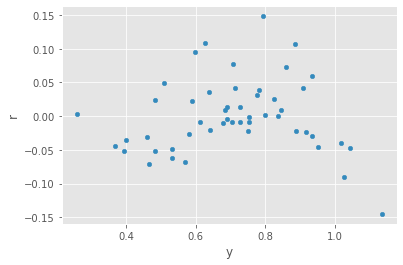

In [59]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

_ = pd.DataFrame({'y': m3.predict(X), 'r': y - m3.predict(X)}).plot(kind='scatter', x='y', y='r')

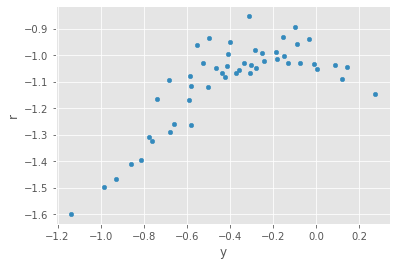

In [60]:
m4 = LinearRegression()
m4.fit(X, np.log(y))

_ = pd.DataFrame({'y': m4.predict(X), 'r': np.log(y) - m3.predict(X)}).plot(kind='scatter', x='y', y='r')

In [49]:
w = np.ones(y.shape[0])

for _ in range(1_000):
    m4 = LinearRegression()
    m4.fit(X, y, w)
    w = 1 / np.abs(y - m4.predict(X))
    w = w / w.sum()
    w = w + 0.0001
    
c4 = pd.concat([
    pd.Series(m4.intercept_, ['intercept']), 
    pd.Series(m4.coef_, X.columns)
])

c4

intercept          0.949171
hosp[T.B]         -0.058580
hosp[T.C]         -0.015018
hosp[T.D]         -0.067297
hosp[T.E]         -0.129439
severe_burn       -0.246746
head_injury       -0.181401
is_senior         -0.106917
male              -0.025848
tertiary_center    0.211753
burn_center       -0.058580
dtype: float64